## Objetivo

El dataset fue extrído de [Kaggle](https://www.kaggle.com/competitions/dog-breed-identification/data). El mismo presenta un problema de clasificación multi-clase, en donde el objetivo es identificar la raza de perros dentro del dataset. El mismo presenta los siguientes archivos:
- **datasets/classification/labels.csv**: contiene la raza de los perros de cada imágen.
- **datasets/classification/dog-breed-identification/train/**: contiene imágenes de entrenamiento.
- **datasets/classification/gog-breed-identification/test/**: contiene imágenes de testeo.

Dada la complejidad del problema en cuestión, se utilizará el approach de **Transfer Learning** utilizando un modelo pre-entrenado para lograr buen poder predictivo.

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import requests
import shutil
import os
from io import BytesIO

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# import scikitplot as skplt

# ML
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Deep Learning
from keras.applications.mobilenet import preprocess_input
from keras.applications import ResNet50V2
from keras.layers import BatchNormalization
from keras.layers import BatchNormalization, GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model
import tensorflow as tf

# Computer Vision
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageDraw, ImageFont

## Explanatory Data Analysis

### Data Loading

In [2]:
# Load targets
labels: pd.DataFrame = pd.read_csv(os.path.join("..", "datasets", "classification", "labels.csv"))

# Define train & test paths
train_dir = os.path.join("..", "datasets", "classification", "dog-breed-identification", "train")
val_dir = os.path.join("..", "datasets", "classification", "dog-breed-identification", "val")
test_dir = os.path.join("..", "datasets", "classification", "dog-breed-identification", "test")

In [3]:
# Show labels
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


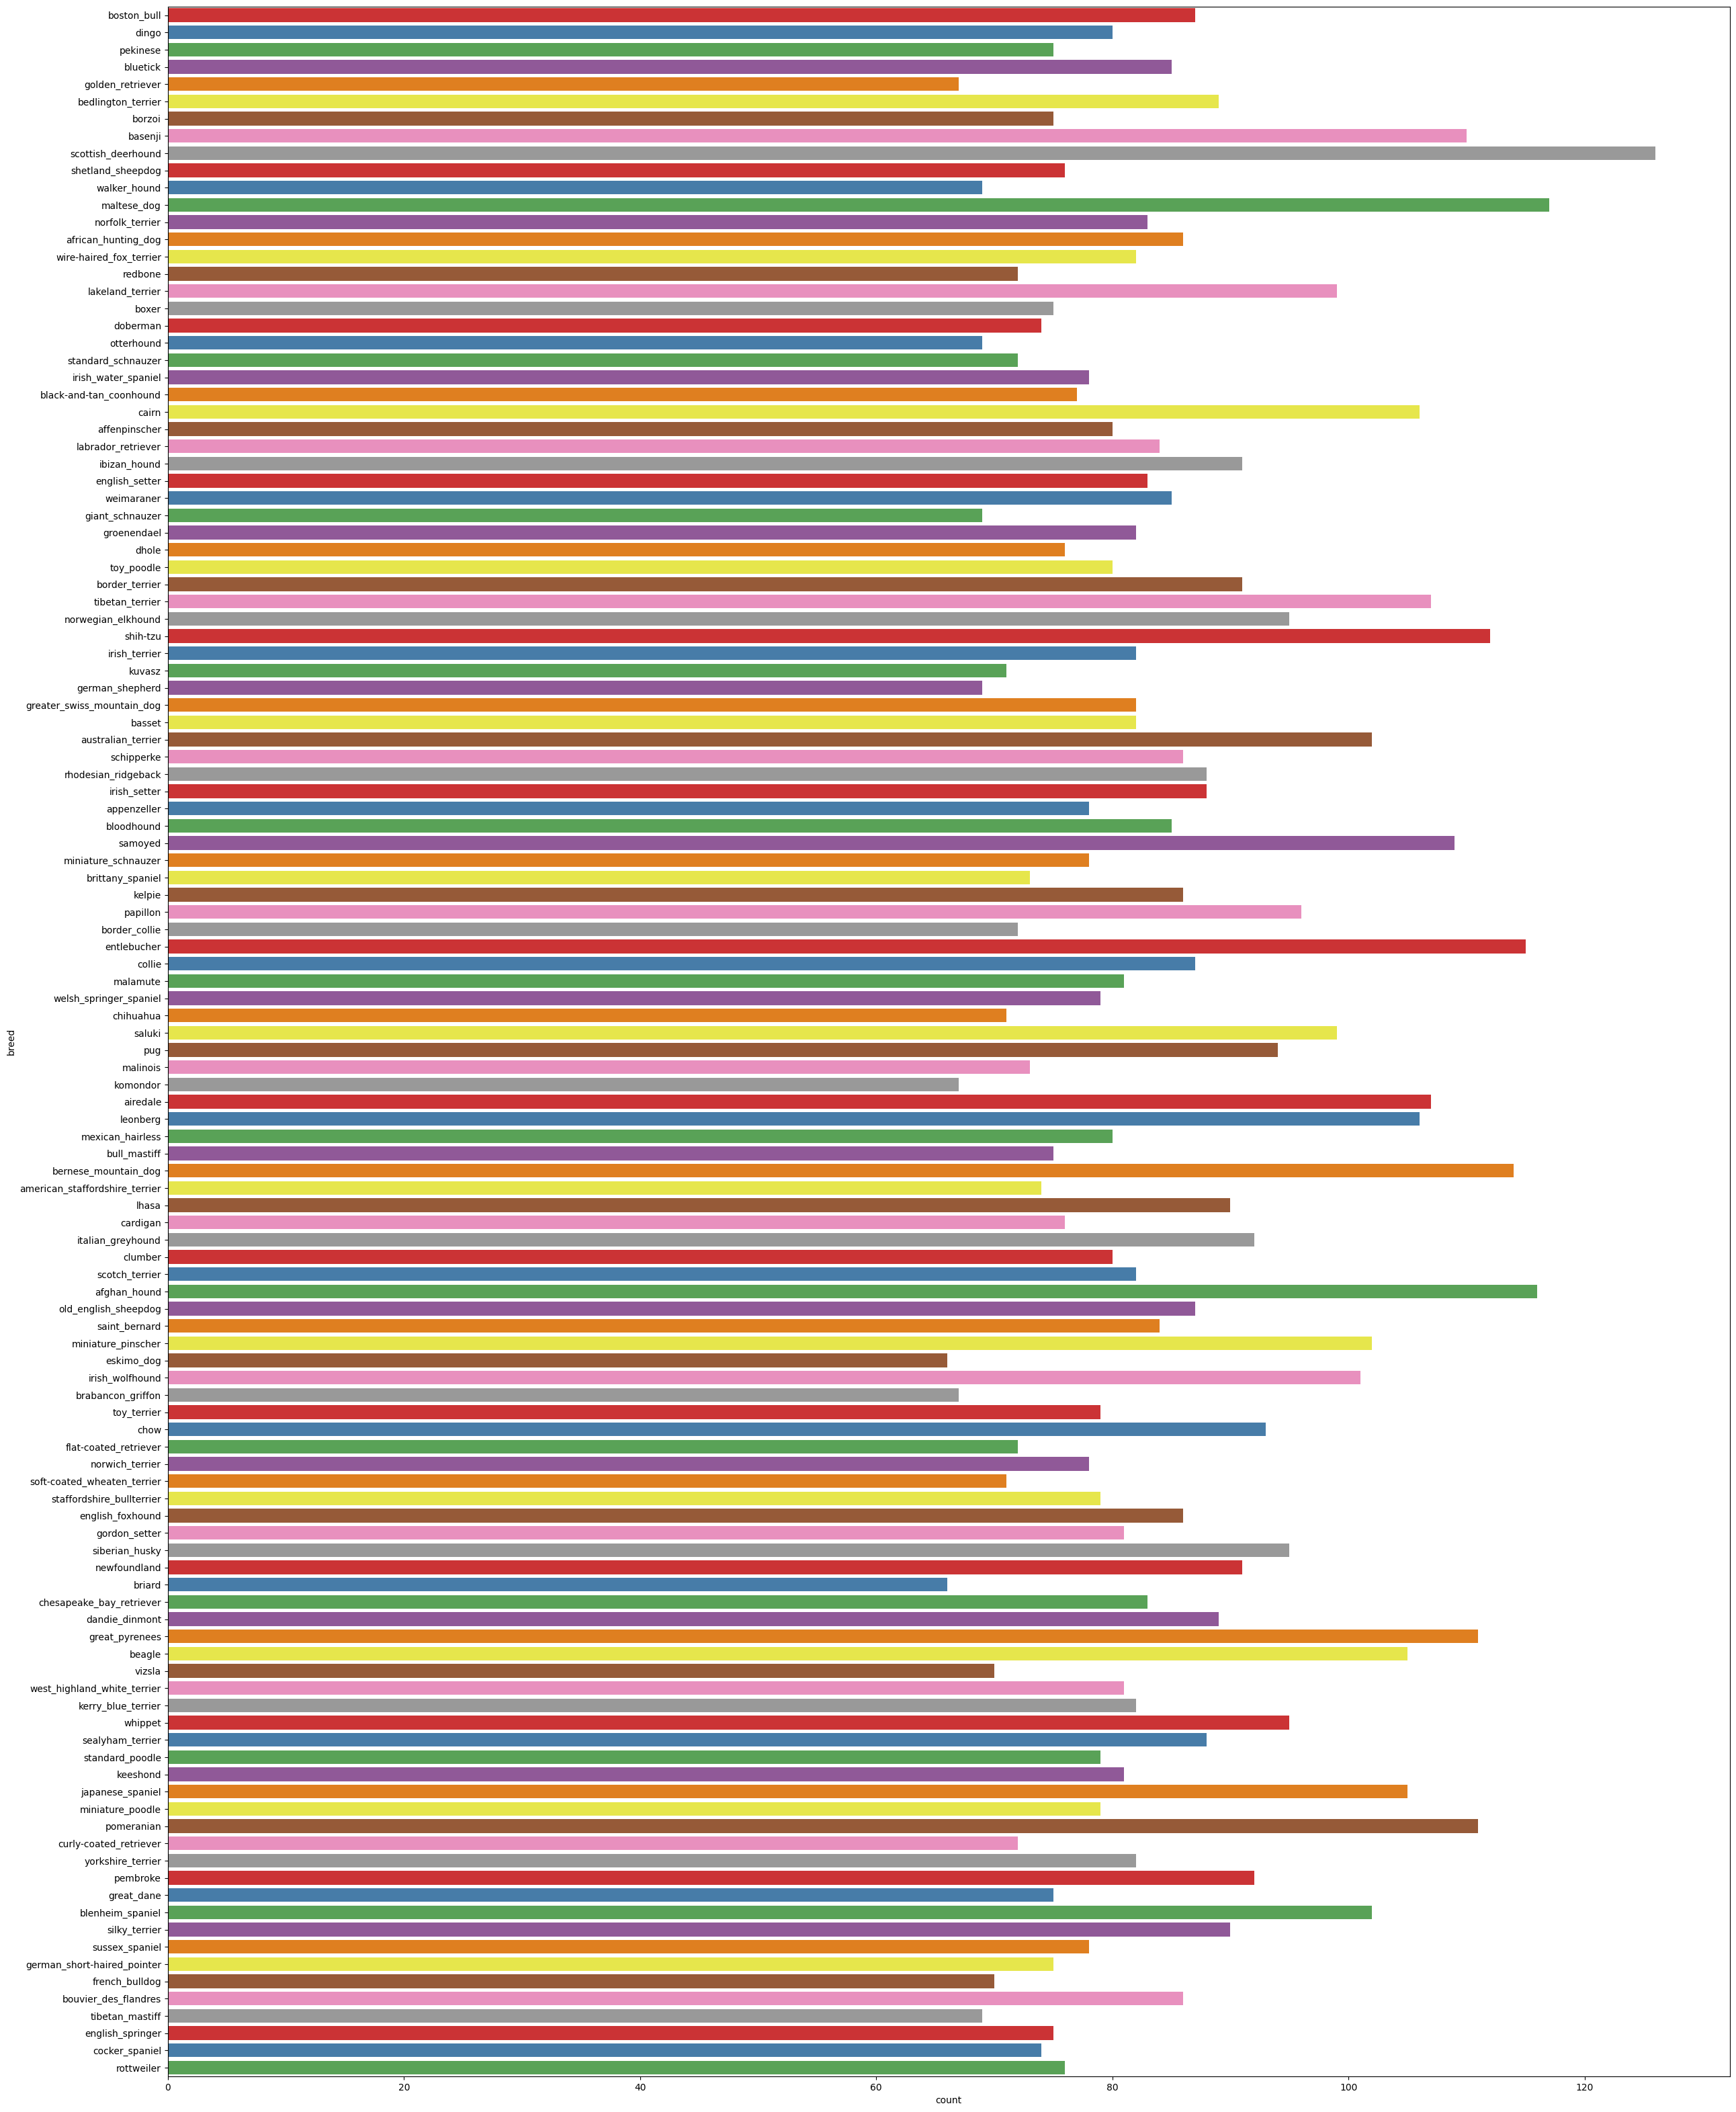

In [4]:
# Show barchart of labels
plt.figure(figsize=(30,40))
sns.countplot(
    y="breed", 
    data=labels,
    palette="Set1",
    hue="breed",
    legend=False
)
plt.show()

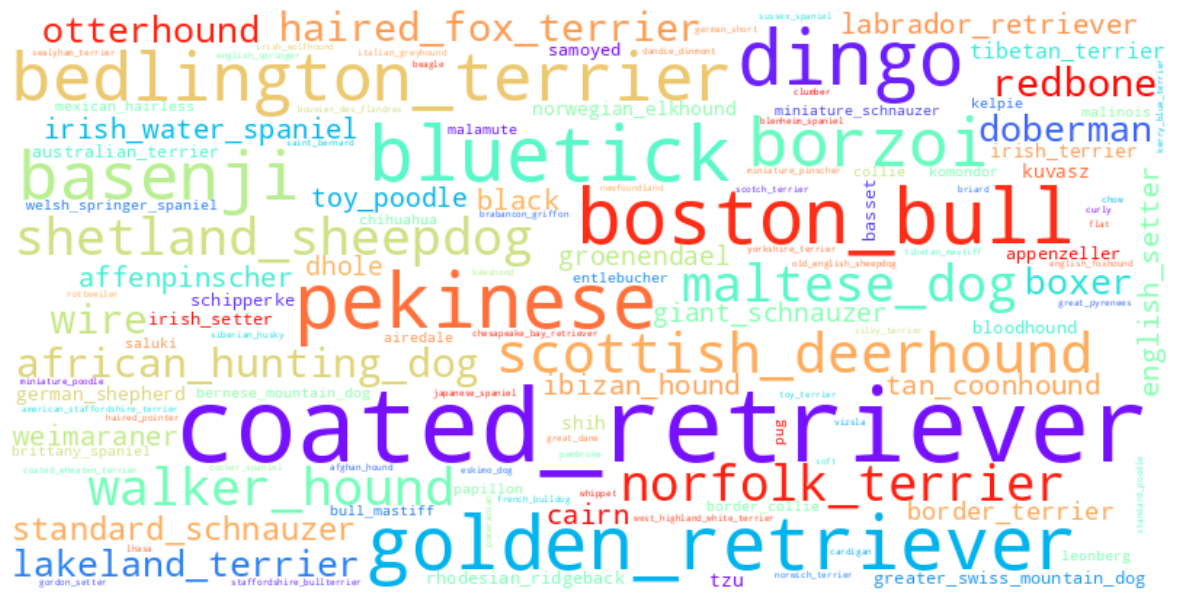

In [5]:
# Show worldcloud for breeds
breeds = labels["breed"].unique().tolist()

text = ' '.join(breeds)
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white',
    colormap="rainbow"
).generate(text)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

[ WARN:0@1.577] global loadsave.cpp:248 findDecoder imread_('../datasets/classification/dog-breed-identification/train/pekinese/001cdf01b096e06d78e9e5112d419397.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1.590] global loadsave.cpp:248 findDecoder imread_('../datasets/classification/dog-breed-identification/train/norfolk_terrier/0075dc49dab4024d12fafe67074d8a81.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1.598] global loadsave.cpp:248 findDecoder imread_('../datasets/classification/dog-breed-identification/train/bedlington_terrier/0097c6242c6f3071762d9f85c3ef1b2f.jpg'): can't open/read file: check file path/integrity


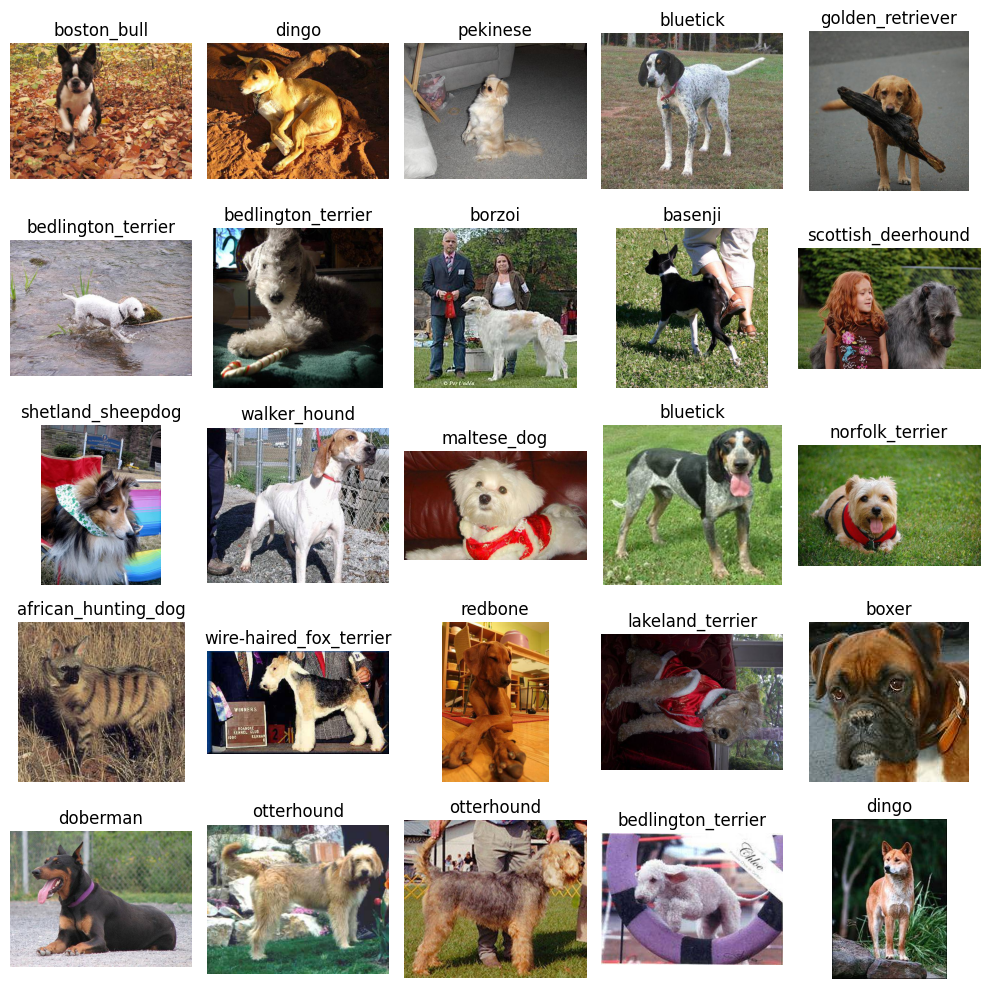

In [6]:
# Visualize train images
nrow = 5
ncol = 5
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10))

for i,(img_id, breed) in enumerate(labels[["id","breed"]].values[: nrow*ncol]):
    # Extract colored image
    image_path = os.path.join(train_dir, breed, img_id + ".jpg")
    image = cv2.imread(image_path)
    
    if image is None:
        image_path = os.path.join(val_dir, breed, img_id + ".jpg")
        image = cv2.imread(image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Define row & col
    row = i // ncol
    col = i % ncol

    # Plot image
    ax[row,col].imshow(image)
    ax[row,col].set_title(breed)
    ax[row,col].axis("off")
    
plt.tight_layout()
plt.show()


In [7]:
num_breed = labels.breed.nunique()
print(f"Total number of unique Dog Breeds: {num_breed}")

Total number of unique Dog Breeds: 120


In [8]:
# Filter labels
breed = list(labels["breed"].value_counts().keys())
new = sorted(breed,reverse=True)[: num_breed]
labels = labels.query("breed in @new")

# Prepare image_file column
labels['image_file'] = labels['id'].apply(lambda x: x + ".jpg")

labels

,id,breed,image_file
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,0021f9ceb3235effd7fcde7f7538ed62.jpg
...,...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi,ffd25009d635cfd16e793503ac5edef0.jpg
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont,ffd3f636f7f379c51ba3648a9ff8254f.jpg
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale,ffe2ca6c940cddfee68fa3cc6c63213f.jpg
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher,ffe5f6d8e2bff356e9482a80a6e29aac.jpg


### Data Processing

In [9]:
# Encode breeds
# encoder = LabelEncoder()
# encoded_breeds = encoder.fit_transform(labels["breed"].values)

In [10]:
# Divide into train & vallidation observations
X_train, X_val, y_train, y_val = train_test_split(
    labels['image_file'],
    labels['breed'],
    stratify=labels['breed'],
    test_size=0.2,
    random_state=23111997
)

In [11]:
# Extract train & validation images
train_images = X_train.values.tolist()
val_images = X_val.values.tolist()

In [12]:
# Move training files into train & validation directories 
# This is required to be consumed by the ImageDataGenerator
for idx, row in labels.iterrows():
    # Extract breed & file
    breed = row['breed']
    file = row['image_file']

    if file in train_images:
        # Build train breed directory
        if not os.path.exists(os.path.join(train_dir, breed)):
            os.mkdir(os.path.join(train_dir, breed))

        # Move train image to correct directory
        src = os.path.join(train_dir, file)
        dst = os.path.join(train_dir, breed, file)

        if os.path.exists(src):
            shutil.move(src=src, dst=dst)

            assert not(os.path.exists(src))

    elif file in val_images:
        # Build val breed directory
        if not os.path.exists(os.path.join(val_dir, breed)):
            os.mkdir(os.path.join(val_dir, breed))

        # Move train image to correct directory
        src = os.path.join(train_dir, file)
        dst = os.path.join(val_dir, breed, file)

        if os.path.exists(src):
            shutil.move(src=src, dst=dst)

            assert not(os.path.exists(src))

    else:
        raise Exception(f"{file} was not found in train/val images.\n")

In [13]:
# Define required parameters
image_size = 200
batch_size = 32

In [14]:
# Utilize data augmentation methods to increase the variety of training images
train_datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define the train generator
train_generator = train_datagen.flow_from_directory(
    # Train directory
    train_dir,
    # Rescale images to image_size x image_size
    target_size=(image_size, image_size),
    # Define batch_size
    batch_size=batch_size,
    # This is a multi-class problem, therefore we will use categorical class_mode
    class_mode='categorical'
)

Found 8177 images belonging to 120 classes.


In [15]:
# Define test generator (without data augmentation)
val_datagen = ImageDataGenerator()

val_generator = val_datagen.flow_from_directory(
    # Validation directory
    val_dir,
    # Rescale images to image_size x image_size
    target_size=(image_size, image_size),
    # Define batch_size
    batch_size=batch_size,
    # This is a multi-class problem, therefore we will use categorical class_mode
    class_mode='categorical'
)

Found 2045 images belonging to 120 classes.


In [16]:
# Extract ResNet50V2 trained model, to be fine tuned
resnet_model = ResNet50V2(
    input_shape=(image_size, image_size) + (3,), 
    weights='imagenet', 
    include_top=False
)

# Make layers not trainable
for layer in resnet_model.layers:
    layer.trainable = False

In [17]:
# Build additional layers after the last layer from ResNet model
x = resnet_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

# Output layer with num_breed units (number of classes), no activation
prediction = Dense(num_breed)(x)

model = Model(
    inputs=resnet_model.input, 
    outputs=prediction
)

In [18]:
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip('horizontal'),
#   tf.keras.layers.RandomRotation(0.2),
# ])

# image_batch, label_batch = next(train_generator)
# feature_batch = resnet_model(image_batch)

# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)

# prediction_layer = tf.keras.layers.Dense(120)
# prediction_batch = prediction_layer(feature_batch_average)

# inputs = tf.keras.Input(shape=(image_size, image_size, 3))
# x = data_augmentation(inputs)
# x = preprocess_input(x)
# x = resnet_model(x, training=False)
# x = global_average_layer(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# outputs = prediction_layer(x)

# model = tf.keras.Model(inputs, outputs)

In [19]:
# Compile Model
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(
    optimizer=optimizer,
    loss=loss, # 'sparse_categorical_crossentropy',
    metrics=["accuracy"]
)

In [20]:
# model.summary()

In [21]:
# Fit model
history = model.fit(
    train_generator,
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=15,
    validation_data=val_generator,
    validation_steps=X_val.shape[0] // batch_size
)

Epoch 1/15


ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None, 120), output.shape=(None, 120)

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(history.history['accuracy'],label="Train_Accuracy",color="blue",marker="*")
plt.plot(history.history['val_accuracy'],label="Validation_Accuracy",color="red",marker="P")
plt.grid(True)
plt.legend()
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(history.history['loss'],color="green",marker="D")
plt.plot(history.history['val_loss'],color="navy",marker="H")
plt.grid(True)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train_Loss', 'Validation_Loss'], loc='upper left')
plt.show()

In [ ]:
pre=model.predict(x_test)
predict=np.argmax(pre,axis=1)

from sklearn.metrics import confusion_matrix, classification_report
plt.figure(figsize=(50,30))
cf=confusion_matrix(y_test,predict)
sns.heatmap(cf,annot=True,fmt="d",cmap="jet",lw=4,linecolor="black",xticklabels=lab,yticklabels=lab)
plt.show()


In [ ]:
print(classification_report(y_test,predict,target_names=lab))

In [ ]:
# pred=model.predict(x_test)
# plt.figure(figsize=(30,20))

skplt.metrics.plot_roc(y_test, pre)
plt.show()

In [ ]:
plt.figure(figsize=(20,15))
skplt.metrics.plot_precision_recall(y_test, pre)
plt.show()

In [ ]:
row = 5
column = 6

fig, ax = plt.subplots(row, column)
fig.set_size_inches(15, 15)

index = 0
for m in range(0, row):
    for n in range(0, column):
        true_data = np.argmax(y_test[index])  # Get the true class label
        pred_data = predict[index]  # Get the predicted class label
        probability = round(pre[index][pred_data], 2)
        ax[m][n].axis("off")
        ax[m][n].set_title("True=" + str(lab[true_data]) + "\nPredict=" + str(lab[pred_data]) + "\nProbability=" + str(probability))
        ax[m][n].imshow(x_test[index])
        index += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.20)
plt.show()


In [ ]:


# Define the URL of the image
image_url = "https://www.dailypaws.com/thmb/KMJM_zupItmjx1g-tAAZ-7L-hbE=/750x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/siberian-husky-100800827-2000-9449ca147e0e4b819bce5189c2411188.jpg"
# Load the image from the URL
response = requests.get(image_url)
image_path = Image.open(BytesIO(response.content))
image_resized_rgb = image_path.resize((224, 224)).convert('RGB')
image_array_rgb = np.array(image_resized_rgb)
image_scale_rgb = image_array_rgb.astype("float32") / 255.0
image_reshape_rgb = image_scale_rgb.reshape(1, 224, 224, 3)  
final_pred = model.predict(image_reshape_rgb)[0]
max_prob = np.argmax(final_pred)
results = lab  
my_predict = results[max_prob]
myFont = ImageFont.truetype('/kaggle/input/hack-font/Hack-Bold.ttf',8)
image_draw = ImageDraw.Draw(image_resized_rgb)
image_draw.text((10, 10), f"Predicted class: {my_predict}", font=myFont, fill=(255, 20, 30))
image_resized_rgb.save("my_image.png")
plt.figure(figsize=(8, 8))
plt.imshow(image_resized_rgb)
plt.axis("off")
plt.show()
